TODO: 
    stain normaliztion
    augmantation
    

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D 
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.vgg19 import VGG19
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
from keras.utils import HDF5Matrix

In [4]:
import os
import gzip
from keras.utils import HDF5Matrix

def load_data(data_dir, purpose='train', limit=None, val_limit=None, norm=None):

    norm = '_' + norm if norm else ''
    
    if purpose == 'train':
        
        pc_train_x_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_x' + norm + '.h5.gz') 
        pc_train_y_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_train_y' + norm + '.h5.gz') 
        pc_valid_y_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_y' + norm + '.h5.gz')
        pc_valid_x_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_valid_x' + norm + '.h5.gz') 
        
        if not norm:
            pc_train_x_h5 = gzip.open(pc_train_x_h5, 'rb')
            pc_train_y_h5 = gzip.open(pc_train_y_h5, 'rb')
            pc_valid_y_h5 = gzip.open(pc_valid_y_h5, 'rb')
            pc_valid_x_h5 = gzip.open(pc_valid_x_h5, 'rb')
        
        x_train = HDF5Matrix(pc_train_x_h5, 'x')
        y_train = HDF5Matrix(pc_train_y_h5, 'y')
        x_valid = HDF5Matrix(pc_valid_x_h5, 'x')
        y_valid = HDF5Matrix(pc_valid_y_h5, 'y')
        
        if not val_limit and limit:
            val_limit = limit
        
        if limit and limit<len(x_train):
            x_train = x_train[:limit]
            y_train = y_train[:limit]
        
        if val_limit and val_limit<len(x_valid):
            x_valid = x_valid[:val_limit]
            y_valid = y_valid[:val_limit]

        return x_train, y_train, x_valid, y_valid

    elif purpose == 'test':
        
        pc_test_x_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_test_x' + norm + '.h5.gz') 
        pc_test_y_h5 = os.path.join(data_dir, 'camelyonpatch_level_2_split_test_y' + norm + '.h5.gz') 
        
        if not norm:
            pc_test_x_h5 = gzip.open(pc_test_x_h5, 'rb')
            pc_test_y_h5 = gzip.open(pc_test_y_h5, 'rb')

        x_test = HDF5Matrix(pc_test_x_h5, 'x')
        y_test = HDF5Matrix(pc_test_y_h5, 'y')

        if limit and limit<len(x_test):
            x_test = x_test[:limit]
            y_test = y_test[:limit]
        
        return x_test, y_test
    
    else:
         print('Please define the purpose. options: "train", "test"' )

### Data birlestirme

In [5]:
import os
import h5py

In [6]:
data_dir = './data/macenko/'

In [7]:
sorted_file_list = sorted([{'file_name': os.path.join(data_dir, fn),
                             'order': int(fn.split('_')[7])}
                            for fn in os.listdir(data_dir) 
                            if ('camelyonpatch_level_2_split_train_x_macenko' in fn
                                and 'ALL' not in fn)],
                          key = lambda i: i['order'])

In [8]:
[f['file_name'] for f in sorted_file_list], len([f['file_name'] for f in sorted_file_list])

(['./data/macenko/camelyonpatch_level_2_split_train_x_macenko_0_10000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_10000_20000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_20000_30000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_30000_40000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_40000_50000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_50000_60000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_60000_70000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_70000_80000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_80000_90000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_90000_100000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_100000_110000.h5.gz',
  './data/macenko/camelyonpatch_level_2_split_train_x_macenko_110000_120000.h5.gz',
  './data/macen

In [ ]:
#keep track of the total number of rows
total_rows = 0

output_file = h5py.File(os.path.join(data_dir, 'camelyonpatch_level_2_split_train_x_macenko_ALL.h5'), 'w')

for n, finfo in enumerate(sorted_file_list):
    
    file_name = finfo['file_name']

    your_data = HDF5Matrix(file_name, 'x')
    total_rows = total_rows + your_data.shape[0]
    total_columns = your_data.shape[1]
    
    print(file_name.split('/')[-1][44:-6], your_data.shape, total_rows, total_columns)

    if n == 0:
        print('Creating dataset')
        #first file; create the dummy dataset with no max shape
        create_dataset = output_file.create_dataset("x", (total_rows, total_columns), maxshape=(None, None))
        #fill the first section of the dataset
        create_dataset[:,:] = your_data
        where_to_start_appending = total_rows

    elif n == 2:
        break
        
    else:
#         resize the dataset to accomodate the new data
        create_dataset.resize(total_rows, axis=0)
        create_dataset[where_to_start_appending:total_rows, :] = your_data
        where_to_start_appending = total_rows

output_file.close()

0_10000 (9990, 96, 96, 3) 9990 96
Creating dataset


# ----- BURAYA KADAR CALISTIR SADECE -----

In [10]:
data_dir = './data/'

In [14]:
pc_train_x_0_20000_h5 = os.path.join(data_dir, 'macenko/camelyonpatch_level_2_split_train_x_macenko_ALL.h5') 

In [15]:
x_train = HDF5Matrix(pc_train_x_0_20000_h5, 'x')

In [9]:
x_train_2 =HDF5Matrix(pc_train_x_10000_20000_h5, 'x')

In [16]:
x_train.shape, type(x_train)

((9990, 96), keras.utils.io_utils.HDF5Matrix)

In [13]:
x_train_2.shape, type(x_train_2)

((9982, 96, 96, 3), keras.utils.io_utils.HDF5Matrix)

In [ ]:
total = 

In [19]:
x_train_all = np.array([])

In [17]:
x_train_all.

AttributeError: 'list' object has no attribute 'shape'

In [14]:
def show(image, now=True, fig_size=(10, 10)):
    """
    Show an image (np.array).
    Caution! Rescales image to be in range [0,1].
    :param image:
    :param now:
    :param fig_size:
    :return:
    """
    image = image.astype(np.float32)
    m, M = image.min(), image.max()
    if fig_size != None:
        plt.rcParams['figure.figsize'] = (fig_size[0], fig_size[1])
    plt.imshow((image - m) / (M - m), cmap='gray')
    plt.axis('off')
    if now == True:
        plt.show()

In [24]:
x_train.shape

(9990, 96, 96, 3)

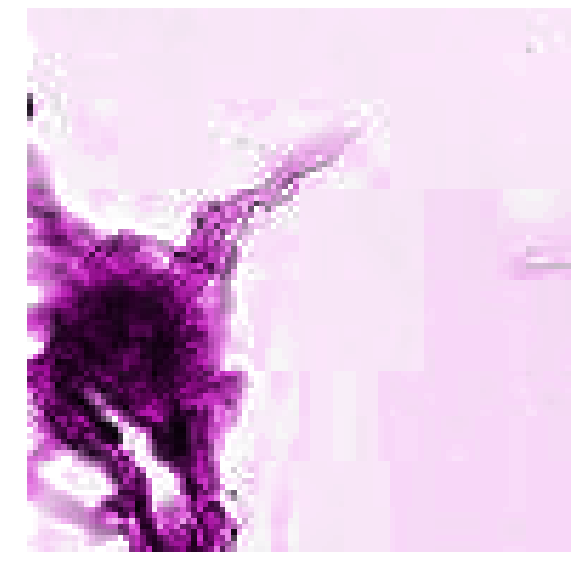

In [21]:
show(x_train[5],now=False)

In [3]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
# from utils.load_data import load_data
from utils.comparams import auc

### Data Generator

In [4]:
data_dir = './data/'

In [7]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', limit=10000, val_limit=None)
len(x_train), len(x_valid)

(10000, 10000)

In [9]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

## MODEL

In [17]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

W0504 23:16:00.665940 140079911899264 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0504 23:16:00.674571 140079911899264 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0504 23:16:00.675964 140079911899264 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0504 23:16:00.690954 140079911899264 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_b

In [18]:
x = vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
#x = Dropout(0.5)(x)
y = Dense(2, activation='softmax')(x) # sigmoid instead of softmax to have independent probabilities

model = Model(inputs=vgg16.input, outputs=y)

# Train only the top layer
for layer in vgg16.layers:
    layer.trainable = False

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Compile

In [19]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

In [20]:
optimizer = Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
loss = 'categorical_crossentropy'
metrics = ['acc', auc]

In [21]:
model.compile(optimizer, loss, metrics)

W0505 16:32:38.429368 140208666730624 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/utils/comparams.py:5: The name tf.metrics.auc is deprecated. Please use tf.compat.v1.metrics.auc instead.



## Train the model

In [1]:
# directory to save the best model
file_dir = './Model'
if not os.path.exists(file_dir):
    os.mkdir(file_dir)
    
model_name = 'vgg16_model_50K'
    
network_filepath = os.path.join(file_dir, model_name + '.h5')

NameError: name 'os' is not defined

In [23]:
# Define batch size.
batch_size = 128
n_epoch = 10
# time_limit = 500 # time limit in minute (500 -> 8 hrs and 20 min)

# Parameters for generators
params = {
    'dim': (224, 224),
    'batch_size': batch_size,
    'n_classes': 2,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **params)

#a function to save last_model compatible with the on_interrupt handler of TimerCallback
def saveWeights(model, elapsed):
    model.save_weights(os.path.join(file_dir, model_name + '_weights.h5'))


# Callbacks,
callbacks = [PlotCurves(), learning_rate_reduction]#, TimerCallback(1, on_interrupt=saveWeights)]
#roc_callback(training_data=training_generator,validation_data=validation_generator)

In [ ]:
# Training with ...
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

Epoch 1/10
389/390 [============================>.] - ETA: 0s - loss: 0.3653 - acc: 0.8400

In [ ]:
model.save(network_filepath)

### Runs

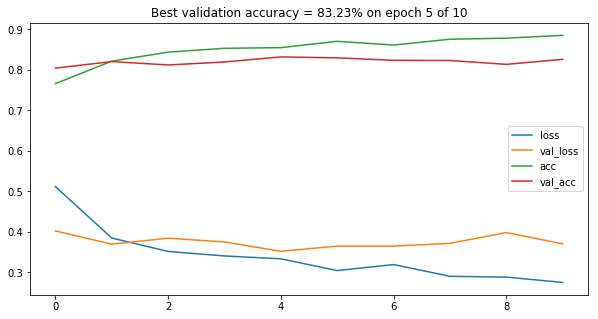

In [23]:
# Training with 10k
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)